In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Preprocessing

In [10]:
import pandas as pd
df=pd.read_csv('drive/My Drive/Colab Notebooks/Final Project/Task 2/train.csv')
# df=pd.read_csv('train.csv')   # my PC
df['label'] = df['label'].astype(str)
df.head()

,image,label
0,0000.png,0
1,0001.png,1
2,0002.png,1
3,0003.png,1
4,0004.png,1


In [11]:
traindf = df.sample(frac=0.75, random_state=777)   # 隨機將train.csv裡的檔案分成train:validation=3:1
validf = df.drop(traindf.index)

display(traindf.head())
display(validf.head())
print('各DataFrame 大小:', len(df), len(traindf), len(validf))

,image,label
3437,3437.png,0
1646,1646.png,1
4035,4035.png,0
2041,2041.png,1
1920,1920.png,0


,image,label
8,0008.png,1
17,0017.png,0
19,0019.png,0
20,0020.png,0
28,0028.png,0


各DataFrame 大小: 5000 3750 1250


In [12]:
import os
from keras.preprocessing.image import ImageDataGenerator

base_dir = "drive/My Drive/Colab Notebooks/Final Project/Task 2"   # Colab 路徑
# base_dir = os.getcwd()   # My PC路徑 (notebook當前路徑)
train_dir = os.path.join(base_dir, 'train_img')
valid_dir = os.path.join(base_dir, 'train_img')
test_dir = os.path.join(base_dir, 'test_img')

BATCH_SIZE = 10
wh =150

train_datagen = ImageDataGenerator(  # data augmentation
        rotation_range=15,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        rescale=1./255., 
        # validation_split=0.25
)
train_generator = train_datagen.flow_from_dataframe( 
    dataframe=traindf,
    directory=train_dir,
    x_col='image',
    y_col='label',
#     has_ext=False,
#     subset="training",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    target_size=(wh, wh)
)

vaild_datagen = ImageDataGenerator(
        rescale=1./255.
)
validation_generator = vaild_datagen.flow_from_dataframe( 
    dataframe=validf,
    directory=valid_dir,
    x_col='image',
    y_col='label',
#     has_ext=False,
#     subset="validation",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    target_size=(wh, wh)
)

# 
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(wh, wh),
    color_mode='rgb',
    shuffle=False,
    class_mode=None
)

Found 3750 validated image filenames belonging to 2 classes.
Found 1250 validated image filenames belonging to 2 classes.
Found 913 images belonging to 1 classes.


Model

In [0]:
from keras.applications.xception import Xception

base = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(wh, wh, 3)
)

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)              

In [0]:
from keras import optimizers

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['acc']
)

Training

In [22]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=50,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50
)

Epoch 1/20
50/50 [==============================] - 9s 184ms/step - loss: 0.3373 - acc: 0.8560 - val_loss: 1.5241 - val_acc: 0.8200
Epoch 2/20
50/50 [==============================] - 9s 174ms/step - loss: 0.3638 - acc: 0.8720 - val_loss: 1.3005 - val_acc: 0.8040
Epoch 3/20
50/50 [==============================] - 9s 174ms/step - loss: 0.4073 - acc: 0.8360 - val_loss: 1.6661 - val_acc: 0.7820
Epoch 4/20
50/50 [==============================] - 9s 176ms/step - loss: 0.2915 - acc: 0.8640 - val_loss: 2.4151 - val_acc: 0.7700
Epoch 5/20
50/50 [==============================] - 9s 174ms/step - loss: 0.4735 - acc: 0.8340 - val_loss: 1.9052 - val_acc: 0.7900
Epoch 6/20
50/50 [==============================] - 9s 172ms/step - loss: 0.4311 - acc: 0.8500 - val_loss: 2.0274 - val_acc: 0.7900
Epoch 7/20
50/50 [==============================] - 9s 175ms/step - loss: 0.4885 - acc: 0.8160 - val_loss: 2.2630 - val_acc: 0.7680
Epoch 8/20
50/50 [==============================] - 9s 182ms/step - loss: 0.

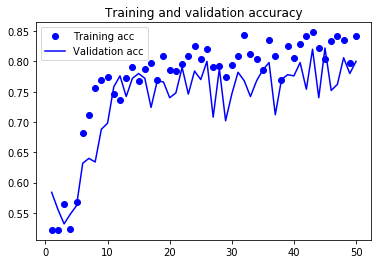

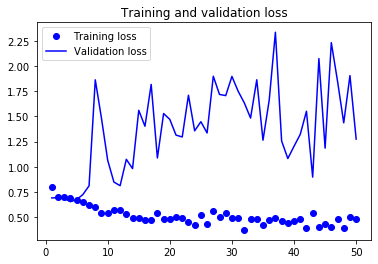

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
# plt.savefig('accu.png')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# plt.savefig('loss.png')

plt.show()

Test

In [0]:
def to_class(i):              # 小數轉成整數
    new = list()
    for e in i:
        if e >= 0.5:
            new.append(1)
        else:
            new.append(0)
    return new

In [0]:
def revise(x):                  # 改filename (留\\後面的檔名就好)
    return x.split('/')[1]

In [0]:
pred = model.predict_generator(test_generator)
# print(len(pred))
# print(pred)

classes = to_class(list(pred.reshape(-1)))

filenames = test_generator.filenames    # Get filenames (set shuffle=false in generator is important)

In [0]:
import numpy as np

np.array(classes).mean()

0.4359255202628697

In [0]:
output = pd.DataFrame(np.array([filenames, classes]).transpose(), columns=['image', 'label'])
output

,image,label
0,test_img/000.png,0
1,test_img/001.png,1
2,test_img/002.png,1
3,test_img/003.png,1
4,test_img/004.png,1
...,...,...
908,test_img/908.png,1
909,test_img/909.png,1
910,test_img/910.png,0
911,test_img/911.png,1


In [0]:
output['image'] = output['image'].apply(revise)
output

,image,label
0,000.png,0
1,001.png,1
2,002.png,1
3,003.png,1
4,004.png,1
...,...,...
908,908.png,1
909,909.png,1
910,910.png,0
911,911.png,1


In [0]:
output.to_csv('drive/My Drive/Colab Notebooks/Final Project/Task 2/Result/wresult8.csv', index=False, encoding='utf-8')    # colab
# output.to_csv('Result/result7.csv', index=False, encoding='utf-8')    # my PC

In [0]:
model.save('drive/My Drive/Colab Notebooks/Final Project/Task 2/task2_1222.h5')    # colab
# model.save('task2_1219.h5')    # my PC